# COVID_Mortality_Forecasting — Messy Data Wrangling & Seasonal Forecasting Case Study

- **Author**: Sam Ginzburg
- **Email**: samginzee@gmail.com
- **Tech Stack**: Python · Pandas · NumPy · Matplotlib · Time Series Analysis

## Modeling Philosophy & Scope

This notebook prioritizes **interpretability, data credibility, and transparency** over predictive precision.

Rather than optimizing for the most accurate point forecasts, the analysis focuses on understanding **seasonal structure**, **cross-country comparability**, and the **limitations imposed by real-world public health data**. Where data quality is strong, seasonal modeling is applied cautiously; where data is volatile, incomplete, or implausible, conclusions are explicitly constrained or reframed.

Forecasts throughout this notebook should be interpreted as **directional and temporal indicators** — highlighting *when* elevated risk may occur — rather than exact predictions of magnitude. In cases of missing or unreliable data, proxy-based methods are used only when assumptions can be clearly justified and communicated.

This approach reflects a core analytical principle:  
> better decisions come from honest models with clear assumptions than from complex models that obscure uncertainty.

The goal is not certainty, but **reasoned insight under imperfect information**.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from scipy.optimize import curve_fit
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import pearsonr


In [33]:
# OK, so first we need to load the data we've created. 
df = pd.read_csv('../data/final_merge.csv')

# Add the columns we'll be using for our analysis
df['new_deceased_over_new_confirmed'] = np.where((df['new_confirmed']!=0)|(df['new_confirmed'].notnull()),(df['new_deceased'] / df['new_confirmed']) * 100,0)
df['new_deceased_over_cumulative_confirmed'] = np.where((df['cumulative_confirmed']!=0)|(df['cumulative_confirmed'].notnull()),(df['new_deceased'] / df['cumulative_confirmed']) * 100,0)
df['cumulative_deceased_over_cumulative_confirmed'] = np.where((df['cumulative_confirmed']!=0)|(df['cumulative_confirmed'].notnull()),(df['cumulative_deceased'] / df['cumulative_confirmed']) * 100,0)
df['cumulative_deceased_over_population'] = np.where((df['population']!=0)|(df['population'].notna()),(df['cumulative_deceased'] / df['population']) * 100,0)

# Create individual dfs for each country
df["country_name_clean"] = (
    df["country_name"]
    .astype(str)
    .str.strip()
    .str.lower()
)

COUNTRY_MAP = {
    "us": {
        "united states of america"
    },
    "italy": {
        "italy"
    },
    "spain": {
        "spain"
    },
    "germany": {
        "germany"
    }
}

df_us = df[df["country_name_clean"].isin(COUNTRY_MAP["us"])].copy()
df_italy = df[df["country_name_clean"].isin(COUNTRY_MAP["italy"])].copy()
df_spain = df[df["country_name_clean"].isin(COUNTRY_MAP["spain"])].copy()
df_germany = df[df["country_name_clean"].isin(COUNTRY_MAP["germany"])].copy()

df_by_country = {
    "United States": df_us,
    "Italy": df_italy,
    "Spain": df_spain,
    "Germany": df_germany
}

for country, df_c in df_by_country.items():
    print(country, df_c.shape)


United States (136, 35)
Italy (131, 35)
Spain (128, 35)
Germany (111, 35)


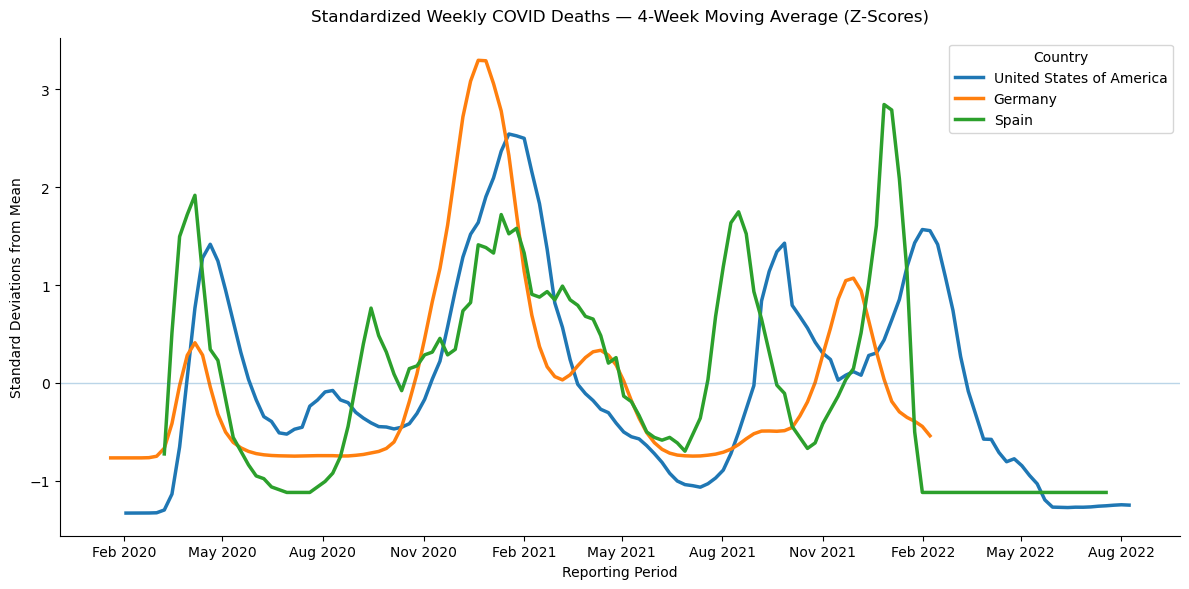

In [34]:
# --------------------------------------------
# Standardized (Z-score) COVID deaths trends
# using a 4-week moving average (MA4)
# --------------------------------------------

countries = ["United States of America", "Germany", "Spain"]

# 1) Ensure datetime
df = df.copy()
df["week_start"] = pd.to_datetime(df["week_start"], errors="coerce")

# 2) Weekly aggregation (deaths)
weekly = (
    df.loc[df["country_name"].isin(countries)]
      .dropna(subset=["week_start", "new_deceased"])
      .assign(new_deceased=pd.to_numeric(df["new_deceased"], errors="coerce"))
      .dropna(subset=["new_deceased"])
      .loc[np.isfinite(df["new_deceased"])]
      .groupby(["country_name", "week_start"], as_index=False)["new_deceased"]
      .sum()
      .sort_values("week_start")
)

# 3) Pivot wide: one column per country
wide = (
    weekly.pivot(index="week_start", columns="country_name", values="new_deceased")
          .sort_index()
)

# 4) 4-week moving average per country (smooth first)
wide_ma4 = wide.rolling(window=4, center=True).mean()

# Optional: drop rows where all countries are NaN after rolling
wide_ma4 = wide_ma4.dropna(how="all")

# 5) Z-score standardization per country (compare trends, not magnitudes)
z_scored_ma4 = (wide_ma4 - wide_ma4.mean()) / wide_ma4.std()

# 6) Plot (clean styling)
fig, ax = plt.subplots(figsize=(12, 6))

for c in countries:
    if c in z_scored_ma4.columns:
        ax.plot(
            z_scored_ma4.index,
            z_scored_ma4[c],
            linewidth=2.5,
            label=c
        )

# Reference line at mean (0)
ax.axhline(0, linewidth=1, alpha=0.3)

ax.set_title("Standardized Weekly COVID Deaths — 4-Week Moving Average (Z-Scores)", pad=12)
ax.set_xlabel("Reporting Period")
ax.set_ylabel("Standard Deviations from Mean")

# Month + Year ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

# Styling cleanup
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(title="Country", loc="upper right")

plt.tight_layout()
plt.show()


### Cross-Country COVID Death Trends — Why Standardization Matters

This figure compares weekly COVID death trends for the **United States, Germany, and Spain**, using a 4-week moving average and **z-score standardization**. Rather than focusing on absolute death counts, this view emphasizes **relative movement over time** — peaks, troughs, and seasonal alignment.

---

#### Motivation: From Raw Counts to Comparable Trends

Initial inspection of raw death counts revealed a fundamental challenge:  
the **scale of deaths differs dramatically across countries**.

- The United States reports far higher absolute deaths due to population size and underlying health factors  
- Germany reports substantially fewer deaths, but with clear seasonal structure  
- Spain’s reported deaths are much lower still, raising early concerns about data completeness  

Because of this divergence in magnitude, direct comparison of raw values obscures meaningful temporal patterns. This motivated the use of **z-score standardization**, which centers each country’s series around its own mean and variance, allowing trends — not levels — to be compared.

---

#### Key Observations from the Standardized View

**1. Strong Early Alignment Between the U.S. and Germany**  
Both countries exhibit remarkably similar seasonal patterns through 2020 and early 2021:
- Peaks in early 2020 and late 2020 / early 2021  
- Lows during summer periods  
This alignment suggests shared seasonal drivers and broadly comparable reporting dynamics during the early phases of the pandemic.

**2. Divergence Begins in 2021**  
From mid-2021 onward, patterns begin to diverge:
- Germany continues to follow a relatively consistent winter-peak / summer-low cycle  
- The U.S. experiences additional peaks in early fall and late winter, with an anomalously low early-winter period  

This divergence aligns with the staggered spread of major variants. The U.S. was hit by **Delta in early fall 2021** and **Omicron in late winter 2022**, both occurring during periods when vaccines were widely available but less effective at preventing transmission.

**3. Spain Displays Irregular and Less Stable Patterns**  
Spain’s standardized trend is noisier and less consistently aligned with the U.S. or Germany. While some peaks coincide temporally, others do not, foreshadowing the data-quality concerns explored later in the notebook.

---

#### Why This View Anchors the Rest of the Analysis

This standardized comparison serves as the **conceptual entry point** for the remainder of the notebook.

It establishes that:
- Cross-country comparisons require normalization  
- Some countries exhibit stable, repeatable seasonality  
- Others show irregularities that warrant skepticism  

Building on these observations, the remainder of the analysis:
- Examines each country individually  
- Assesses data reliability and structural breaks  
- Applies seasonal modeling where appropriate  
- Attempts 52-week forecasts while explicitly communicating uncertainty  

---

#### Key Insight

Standardization does not remove differences between countries — it clarifies them.

By stripping away scale, this view reveals where patterns genuinely align, where they diverge, and where data quality may limit interpretation. These insights directly inform the modeling choices, exclusions, and caveats that follow throughout the notebook.


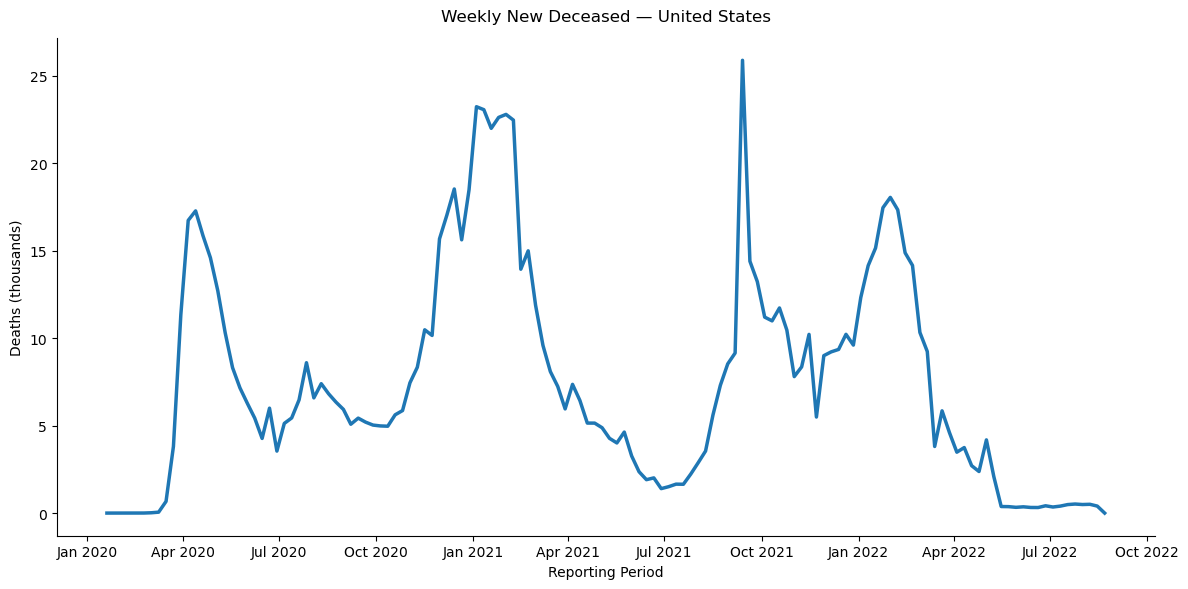

In [35]:
# Ensure datetime typing
df_us["week_start"] = pd.to_datetime(df_us["week_start"], errors="coerce")

# Aggregate weekly deaths
us_weekly = (
    df_us
    .groupby("week_start", as_index=False)["new_deceased"]
    .sum()
    .sort_values("week_start")
    .dropna(subset=["week_start"])
)

# Convert to thousands
us_weekly["new_deceased_k"] = us_weekly["new_deceased"] / 1000.0

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    us_weekly["week_start"],
    us_weekly["new_deceased_k"],
    linewidth=2.5
)

# Titles & labels
ax.set_title("Weekly New Deceased — United States", pad=12)
ax.set_xlabel("Reporting Period")
ax.set_ylabel("Deaths (thousands)")

# Month + Year x-axis formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

# Styling cleanup
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

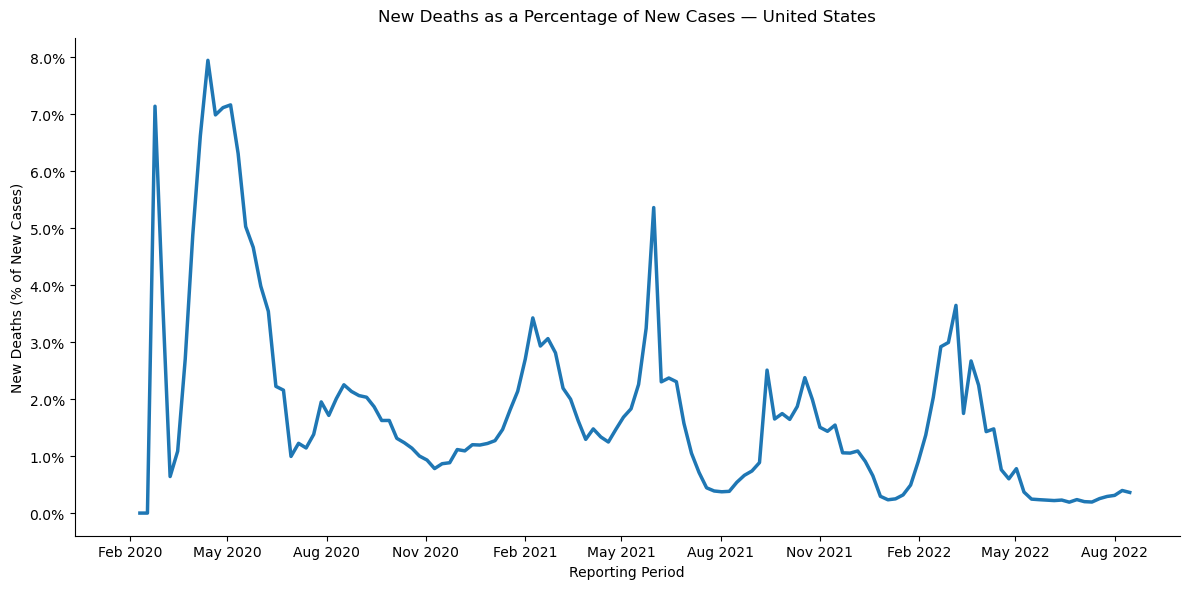

In [36]:
# Compute weekly ratio as (sum deaths) / (sum cases)  [recommended]
us_weekly_ratio = (
    df_us
    .groupby("week_start", as_index=True)[["new_deceased", "new_confirmed"]]
    .sum()
    .sort_index()
)

us_weekly_ratio["death_over_case"] = (
    us_weekly_ratio["new_deceased"] / us_weekly_ratio["new_confirmed"]
)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    us_weekly_ratio.index,
    us_weekly_ratio["death_over_case"],
    linewidth=2.5
)

ax.set_title("New Deaths as a Percentage of New Cases — United States", pad=12)
ax.set_xlabel("Reporting Period")
ax.set_ylabel("New Deaths (% of New Cases)")

# Y axis as percent (expects 0–1)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

# Month + Year x-axis
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

# Styling cleanup
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


In [37]:
# --- Helpers ---
def sinusoidal_fixed_period(x, a, c, d):
    b = 2 * np.pi / 52
    return a * np.sin(b * x + c) + d

def fit_sinusoid_fixed_period(y_values):
    x = np.arange(len(y_values), dtype=float)
    y = np.asarray(y_values, dtype=float)
    p0 = [y.max() - y.min(), 0.0, y.mean()]
    params, _ = curve_fit(sinusoidal_fixed_period, x, y, p0=p0, maxfev=20000)
    return params  # (a, c, d)

# --- 1) Weekly raw deaths series from df_us ---
df_us["week_start"] = pd.to_datetime(df_us["week_start"], errors="coerce")

us_weekly_raw = (
    df_us.dropna(subset=["week_start", "new_deceased"])
        .loc[np.isfinite(df_us["new_deceased"])]
        .groupby("week_start", as_index=True)["new_deceased"]
        .sum()
        .sort_index()
)

# 4-week moving average for plotting
us_weekly_ma4 = us_weekly_raw.rolling(window=4, center=True).mean()

# --- 2) Fit sinusoid to ALL data (raw) ---
params_all = fit_sinusoid_fixed_period(us_weekly_raw.values)

# --- 3) Fit sinusoid to 2021+ only (raw) ---
us_weekly_raw_2021 = us_weekly_raw[us_weekly_raw.index.year >= 2021]
params_2021 = fit_sinusoid_fixed_period(us_weekly_raw_2021.values)

# --- 4) Build x for plotting fits on the FULL timeline ---
x_full = np.arange(len(us_weekly_raw), dtype=float)
x_fit = np.linspace(x_full.min(), x_full.max(), 1000)

# Fit for ALL data on full range
y_fit_all = sinusoidal_fixed_period(x_fit, *params_all)

# Fit for 2021+:
# We need to align the 2021 fit "x=0 at 2021 start" to the full timeline.
start_2021_pos = np.where(us_weekly_raw.index.year >= 2021)[0][0]  # first index position in full series
x_fit_2021_aligned = x_fit - start_2021_pos
y_fit_2021 = sinusoidal_fixed_period(x_fit_2021_aligned, *params_2021)

# Convert x_fit to date axis
date_index = us_weekly_raw.index
date_positions = np.arange(len(date_index), dtype=float)
date_fit_num = np.interp(x_fit, date_positions, mdates.date2num(date_index.to_pydatetime()))
date_fit = mdates.num2date(date_fit_num)


# --- 6) Interactive toggle between fits ---

mode = widgets.ToggleButtons(
    options=[("All data (2020+)", "all"), ("2021 onwards", "2021")],
    description="Fit:",
)

def plot_toggle(which):
    # choose params
    if which == "all":
        y_fit = y_fit_all
        title_suffix = "All data (2020+)"
    else:
        y_fit = y_fit_2021
        title_suffix = "2021 onwards"

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(us_weekly_ma4.index, us_weekly_ma4.values, linewidth=2.5, label="Deaths (4-week Moving Average)")
    ax.plot(date_fit, y_fit, linewidth=2.5, label=f"Sinusoidal Fit ({title_suffix}; 52-week period)")

    ax.set_title(f"US Weekly Deaths — MA(4) vs Sinusoidal Fit ({title_suffix})", pad=12)
    ax.set_xlabel("Reporting Period")
    ax.set_ylabel("Weekly New Deaths")

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(title="Legend", loc="upper right")
    plt.tight_layout()
    plt.show()

out = widgets.interactive_output(plot_toggle, {"which": mode})
display(mode, out)




ToggleButtons(description='Fit:', options=(('All data (2020+)', 'all'), ('2021 onwards', '2021')), value='all'…

Output()

### U.S. Seasonal Modeling — Comparing 2020+ vs 2021+ Sinusoidal Fits

To model seasonality in U.S. COVID deaths, a fixed-period (52-week) sinusoidal regression was applied to weekly death counts. Two alternative fitting windows were intentionally tested:

- **All available data (2020+)**
- **2021 onward**, excluding the early-pandemic period

An interactive toggle was added to the notebook to allow side-by-side visual comparison of the two fits, making differences in alignment immediately apparent.

---

#### Why the 2021+ Fit Performs Better

The early months of 2020 represent a structural break in the data: reporting practices were inconsistent, testing was limited, and mortality patterns were dominated by shock effects rather than recurring seasonality. When this period is included in the regression, the fitted sinusoid attempts to absorb irregular spikes that are not representative of later dynamics.

By contrast, restricting the fit to **2021 onward** produces a markedly cleaner seasonal signal:

- Peaks and troughs are smoother and more symmetric  
- The phase of the sinusoid aligns more closely with observed winter and summer mortality cycles  
- The amplitude better reflects post-vaccine-era variability rather than crisis-driven extremes  

Most notably, the **2021+ fit tracks the observed peaks and troughs of 2022 much more closely**, both in timing and magnitude, indicating that it captures the dominant seasonal structure present in the stabilized portion of the data.

---

#### Role of Interactivity

The interactive toggle is not cosmetic — it serves an analytical purpose. By allowing the viewer to switch between fits on the same underlying series, the impact of time-window selection becomes immediately visible, reinforcing why model assumptions and data inclusion choices matter in time-series analysis.

---

#### Key Insight

Seasonal models are highly sensitive to structural breaks. In this case, excluding 2020 — a period dominated by reporting noise and one-time shocks — yields a more interpretable, defensible seasonal model and a more credible downstream forecast.

Rather than maximizing data quantity, this analysis prioritizes **data relevance and stability**, mirroring the kinds of trade-offs analysts must make in real-world modeling environments.


Fitted parameters (fixed 52-week period) on 2021+ raw weekly deaths:
a (amplitude): -7435.011583331218
c (phase shift): -1.3626817483007592
d (vertical shift): 8515.039060429655


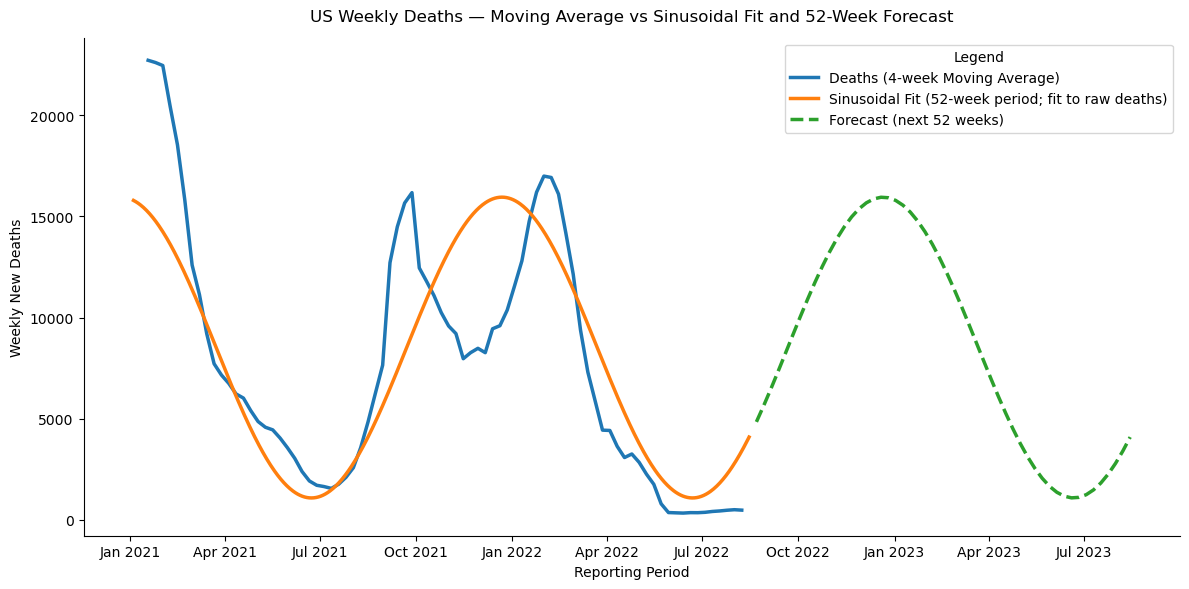

In [38]:
# --- Sinusoid with fixed 52-week period ---
def sinusoidal_fixed_period(x, a, c, d):
    b = 2 * np.pi / 52
    return a * np.sin(b * x + c) + d

# --- 1) Build US weekly raw deaths (2021+) from df_us ---
df_us["week_start"] = pd.to_datetime(df_us["week_start"], errors="coerce")

us_weekly_raw_2021 = (
    df_us.loc[df_us["week_start"].dt.year >= 2021]
    .dropna(subset=["week_start", "new_deceased"])
    .loc[np.isfinite(df_us.loc[df_us["week_start"].dt.year >= 2021, "new_deceased"])]
    .groupby("week_start", as_index=True)["new_deceased"]
    .sum()
    .sort_index()
)

# Continuous week index for fitting
x_data = np.arange(len(us_weekly_raw_2021), dtype=float)
y_data = us_weekly_raw_2021.values.astype(float)

# --- 2) Fit sinusoid to RAW weekly deaths (2021+) ---
p0 = [y_data.max() - y_data.min(), 0.0, y_data.mean()]
params, _ = curve_fit(sinusoidal_fixed_period, x_data, y_data, p0=p0, maxfev=10000)
a, c, d = params

print("Fitted parameters (fixed 52-week period) on 2021+ raw weekly deaths:")
print(f"a (amplitude): {a}")
print(f"c (phase shift): {c}")
print(f"d (vertical shift): {d}")

# Fitted values on historical range
x_fit_hist = np.linspace(x_data.min(), x_data.max(), 800)
y_fit_hist = sinusoidal_fixed_period(x_fit_hist, *params)

# --- 3) Forecast next 52 weeks ---
next_52_weeks = np.arange(x_data.max() + 1, x_data.max() + 53, dtype=float)
next_52_predictions = sinusoidal_fixed_period(next_52_weeks, *params)

last_date = us_weekly_raw_2021.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=52, freq="W-MON")

predictions_df = pd.DataFrame(
    {"week_start": future_dates, "predicted_new_deceased": next_52_predictions}
)


# Optional guardrail (often sensible for deaths): uncomment to prevent negative forecasts
# predictions_df["predicted_new_deceased"] = predictions_df["predicted_new_deceased"].clip(lower=0)

# --- 4) Moving average for plotting (smoother observed deaths) ---
us_weekly_ma4 = us_weekly_raw_2021.rolling(window=4, center=True).mean()

# --- 5) Convert x (continuous weeks) -> dates for plotting the sinusoid curves ---
date_index = us_weekly_raw_2021.index
date_positions = np.arange(len(date_index), dtype=float)

# historical fit dates
hist_fit_dates_num = np.interp(x_fit_hist, date_positions, mdates.date2num(date_index.to_pydatetime()))
hist_fit_dates = mdates.num2date(hist_fit_dates_num)

# forecast dates are already built as future_dates

# --- 6) Plot with your preferred styling ---
fig, ax = plt.subplots(figsize=(12, 6))

# Smooth observed deaths (MA4) — no dots
ax.plot(
    us_weekly_ma4.index,
    us_weekly_ma4.values,
    linewidth=2.5,
    label="Deaths (4-week Moving Average)"
)

# Sinusoidal fit on historical period (fit to raw deaths)
ax.plot(
    hist_fit_dates,
    y_fit_hist,
    linewidth=2.5,
    label="Sinusoidal Fit (52-week period; fit to raw deaths)"
)

# Forecast next 52 weeks (dates)
ax.plot(
    predictions_df["week_start"],
    predictions_df["predicted_new_deceased"],
    linewidth=2.5,
    linestyle="--",
    label="Forecast (next 52 weeks)"
)

# Titles & labels
ax.set_title("US Weekly Deaths — Moving Average vs Sinusoidal Fit and 52-Week Forecast", pad=12)
ax.set_xlabel("Reporting Period")
ax.set_ylabel("Weekly New Deaths")

# Month + Year ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

# No gridlines + clean spines
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(title="Legend", loc="upper right")

plt.tight_layout()
plt.show()

### U.S. Seasonal Forecast — 52-Week Projection Using the 2021+ Fit

Building on the prior comparison of fitting windows, the **2021 onward sinusoidal regression** was selected as the basis for forecasting U.S. COVID deaths over the next 52 weeks.

This choice reflects a deliberate modeling decision: the post-2021 period exhibits more stable reporting practices and a clearer seasonal structure, whereas early-2020 data introduces shock-driven volatility that degrades the interpretability of a seasonal model.

---

#### Forecast Construction

- The sinusoid is fit to **raw weekly deaths (2021+)** using a fixed 52-week period
- Observed deaths are plotted as a **4-week moving average** to emphasize trend over noise
- The fitted seasonal curve is extended **52 weeks forward** to generate a forecast
- Forecast values are shown as a dashed continuation of the fitted sinusoid

This approach isolates the recurring seasonal component while avoiding overfitting short-term fluctuations.

---

#### How to Interpret This Forecast

This projection is **not intended as a precise point forecast**. COVID mortality remains influenced by factors that are not explicitly modeled here, including:

- Variant emergence  
- Behavioral shifts and policy responses  
- Vaccine uptake and waning immunity  
- Reporting delays and revisions  

Instead, the forecast should be interpreted as a **directional, seasonality-driven outlook** that highlights expected **timing and relative magnitude** of future peaks and troughs under broadly similar conditions.

Notably, the forecasted peaks and troughs align closely with patterns observed in 2022, reinforcing that the model is capturing the dominant seasonal rhythm present in the stabilized portion of the data.

--- 

#### Key Insight

When applied thoughtfully, simple seasonal models can still provide meaningful signal — not by predicting exact outcomes, but by clarifying **expected movement**, **cycle timing**, and **risk windows**.

This section emphasizes a core analytical principle:  
> A transparent, assumption-aware model is often more useful than a complex one that obscures its limitations.

The goal here is not certainty, but **structured expectation**.


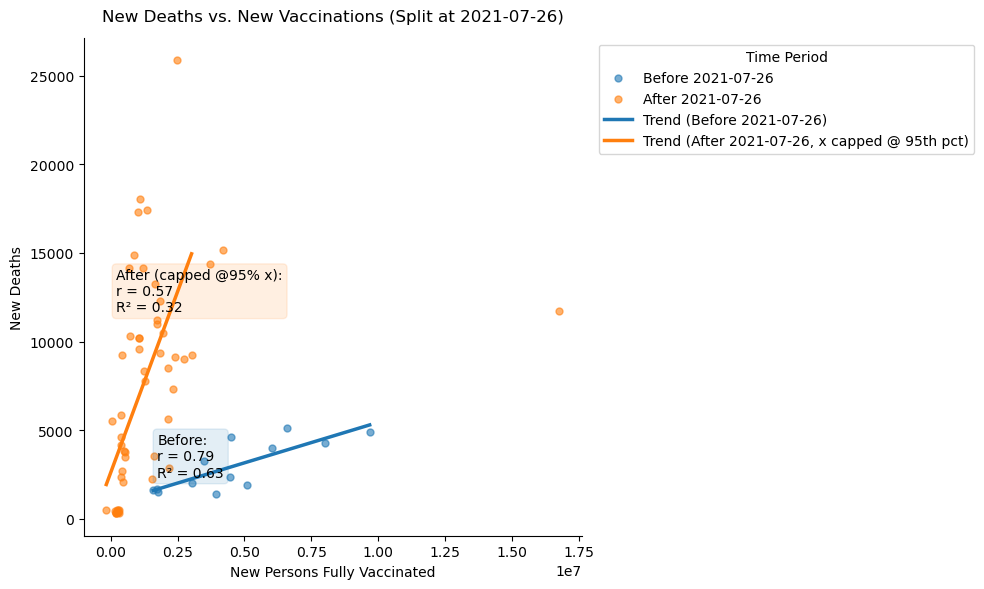

In [39]:
cutoff_date = pd.to_datetime("2021-07-26")

# --- Prep ---
usa_data4 = df_us.loc[~df_us["new_persons_fully_vaccinated"].isna()].copy()
usa_data4["week_start"] = pd.to_datetime(usa_data4["week_start"], errors="coerce")

usa_data4 = usa_data4.dropna(subset=["week_start", "new_deceased", "new_persons_fully_vaccinated"])
usa_data4["new_persons_fully_vaccinated"] = pd.to_numeric(usa_data4["new_persons_fully_vaccinated"], errors="coerce")
usa_data4["new_deceased"] = pd.to_numeric(usa_data4["new_deceased"], errors="coerce")
usa_data4 = usa_data4.dropna(subset=["new_persons_fully_vaccinated", "new_deceased"])
usa_data4 = usa_data4[
    np.isfinite(usa_data4["new_persons_fully_vaccinated"]) &
    np.isfinite(usa_data4["new_deceased"])
].sort_values("week_start")

before = usa_data4["week_start"] < cutoff_date
after  = usa_data4["week_start"] >= cutoff_date

# Pull arrays
x_b = usa_data4.loc[before, "new_persons_fully_vaccinated"].values.astype(float)
y_b = usa_data4.loc[before, "new_deceased"].values.astype(float)

x_a = usa_data4.loc[after, "new_persons_fully_vaccinated"].values.astype(float)
y_a = usa_data4.loc[after, "new_deceased"].values.astype(float)

# Cap AFTER x at 95th percentile (for fit + stats only)
cap = np.quantile(x_a, 0.95)
mask_cap = x_a <= cap
x_a_cap = x_a[mask_cap]
y_a_cap = y_a[mask_cap]

def fit_line_and_stats(x, y):
    m, b = np.polyfit(x, y, 1)
    r, _ = pearsonr(x, y)
    return m, b, r, r**2

m_b, b_b, r_b, r2_b = fit_line_and_stats(x_b, y_b)
m_a, b_a, r_a, r2_a = fit_line_and_stats(x_a_cap, y_a_cap)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter
ax.scatter(x_b, y_b, alpha=0.6, s=25, label=f"Before {cutoff_date.date()}")
ax.scatter(x_a, y_a, alpha=0.6, s=25, label=f"After {cutoff_date.date()}")

# Trendlines (solid)
xline_b = np.linspace(x_b.min(), x_b.max(), 100)
ax.plot(xline_b, m_b * xline_b + b_b, linewidth=2.5, label=f"Trend (Before {cutoff_date.date()})")

xline_a = np.linspace(x_a_cap.min(), x_a_cap.max(), 100)
ax.plot(xline_a, m_a * xline_a + b_a, linewidth=2.5, label=f"Trend (After {cutoff_date.date()}, x capped @ 95th pct)")

# --- Color-coded, labeled stats boxes ---
# Grab the actual colors Matplotlib used (so boxes always match)
blue = ax.lines[0].get_color()
orange = ax.lines[1].get_color()

# Place stats near each cluster using DATA coordinates (not axes coords)
# BEFORE box near the blue cluster
ax.text(
    np.quantile(x_b, 0.10),
    np.quantile(y_b, 0.90),
    f"Before:\nr = {r_b:.2f}\nR² = {r2_b:.2f}",
    fontsize=10,
    va="top",
    bbox=dict(boxstyle="round,pad=0.3", facecolor=blue, alpha=0.12, edgecolor=blue)
)

# AFTER box near the orange cluster (use capped x for placement)
ax.text(
    np.quantile(x_a_cap, 0.10),
    np.quantile(y_a_cap, 0.90),
    f"After (capped @95% x):\nr = {r_a:.2f}\nR² = {r2_a:.2f}",
    fontsize=10,
    va="top",
    bbox=dict(boxstyle="round,pad=0.3", facecolor=orange, alpha=0.12, edgecolor=orange)
)

# Titles & labels
ax.set_title(f"New Deaths vs. New Vaccinations (Split at {cutoff_date.date()})", pad=12)
ax.set_xlabel("New Persons Fully Vaccinated")
ax.set_ylabel("New Deaths")

# Styling cleanup
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Legend outside so nothing overlaps
ax.legend(title="Time Period", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


### New Deaths vs. New Vaccinations — Interpreting a Split Relationship (U.S. Only)

This section examines the relationship between **weekly new COVID deaths** and **weekly new persons fully vaccinated** in the United States. Unlike prior analyses, this comparison reveals two distinct trendlines when the data is split at **July 26, 2021**.

Importantly, this analysis is **unique to the U.S.**, as comparable vaccination data was not consistently available for other countries.

---

#### What the Visualization Shows

- **Before July 26, 2021**  
  A strong, low slope, positive correlation is observed between new vaccinations and new deaths 

- **After July 26, 2021**  
  A weaker, high slope, positive correlation remains  
  Extreme vaccination outliers are capped at the 95th percentile to prevent leverage-driven distortion.

At face value, this relationship appears counterintuitive: higher vaccination counts coinciding with higher death counts.

---

#### Why This Is Not Evidence That Vaccines Increase Deaths

This plot **does not imply causation**, and interpreting it as such would be incorrect. Several confounding dynamics explain why this pattern can emerge:

**1. Timing and Variant Effects (Delta Period)**  
The split date coincides with the emergence and spread of the Delta variant. During this phase:
- Case severity increased
- Vaccine protection against infection (though not severe outcomes) declined
- Booster campaigns had not yet begun  

This introduces a **structural change** in the pandemic environment rather than a failure of vaccination itself.

**2. Behavioral Feedback (“Chicken-and-Egg” Dynamics)**  
Vaccination behavior is **reactive**, not random:
- Rising deaths and hospitalizations increase perceived risk
- Increased perceived risk drives vaccination uptake  

Under this mechanism, higher vaccination rates are a *response* to worsening outcomes — not their cause.

**3. Aggregation Effects**  
Both variables are aggregated at the weekly national level. This obscures:
- Age stratification
- Regional heterogeneity
- Time lags between vaccination and protection  

As a result, contemporaneous correlations can reflect **shared external drivers** rather than direct relationships.

---

#### Why the Split Still Matters

Although the interpretation is complex, the split itself is analytically meaningful:

- The **pre-split period** reflects vaccine rollout during crisis response
- The **post-split period** reflects vaccination during endemic-like waves, variant churn, and behavioral adaptation
- The weakening correlation suggests changing dynamics rather than stability

This reinforces a broader theme of the notebook:  
**relationships observed early in the pandemic do not generalize cleanly to later periods**.

---

#### Key Insight

This section highlights a critical analytical principle:

> Correlation patterns in public health data are often dominated by timing, behavior, and external shocks — not simple cause-and-effect relationships.

Rather than producing a clean narrative, this analysis intentionally surfaces ambiguity. Recognizing when a result is *confounded*, *context-dependent*, or *non-causal* is as important as identifying strong statistical signals.

The goal here is not to explain the pandemic with a single regression line, but to demonstrate disciplined skepticism when the data resists simple interpretation.


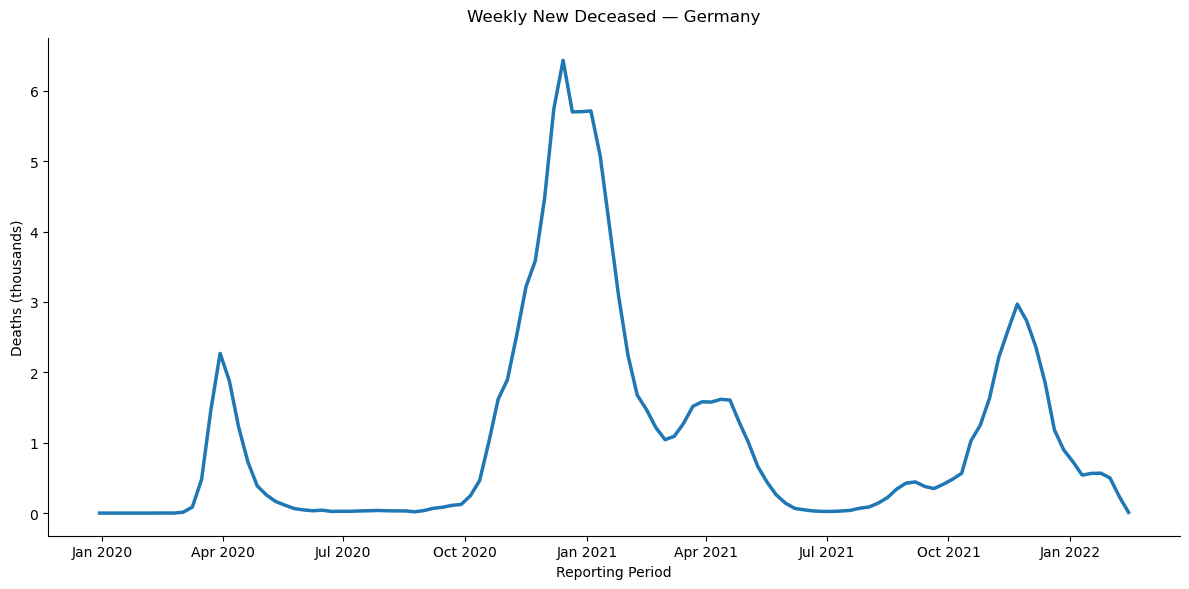

In [40]:
# Germany

# Ensure datetime typing
df_germany["week_start"] = pd.to_datetime(df_germany["week_start"], errors="coerce")

# Aggregate weekly deaths
germany_weekly = (
    df_germany
    .groupby("week_start", as_index=False)["new_deceased"]
    .sum()
    .sort_values("week_start")
    .dropna(subset=["week_start"])
)

# Convert to thousands
germany_weekly["new_deceased_k"] = germany_weekly["new_deceased"] / 1000.0

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    germany_weekly["week_start"],
    germany_weekly["new_deceased_k"],
    linewidth=2.5
)

# Titles & labels
ax.set_title("Weekly New Deceased — Germany", pad=12)
ax.set_xlabel("Reporting Period")
ax.set_ylabel("Deaths (thousands)")

# Month + Year x-axis formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

# Styling cleanup
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

In [41]:
# --- Helpers ---
def sinusoidal_fixed_period(x, a, c, d):
    b = 2 * np.pi / 52
    return a * np.sin(b * x + c) + d

def fit_sinusoid_fixed_period(y_values):
    x = np.arange(len(y_values), dtype=float)
    y = np.asarray(y_values, dtype=float)
    p0 = [y.max() - y.min(), 0.0, y.mean()]
    params, _ = curve_fit(sinusoidal_fixed_period, x, y, p0=p0, maxfev=20000)
    return params  # (a, c, d)

def clip0(arr):
    return np.clip(arr, 0, None)

# --- 1) Weekly raw deaths series from df_germany ---
df_germany["week_start"] = pd.to_datetime(df_germany["week_start"], errors="coerce")

germany_weekly_raw = (
    df_germany.dropna(subset=["week_start", "new_deceased"])
        .loc[np.isfinite(df_germany["new_deceased"])]
        .groupby("week_start", as_index=True)["new_deceased"]
        .sum()
        .sort_index()
)

# 4-week moving average for plotting (smooth observed deaths)
germany_weekly_ma4 = germany_weekly_raw.rolling(window=4, center=True).mean()

# --- 2) Fit sinusoid to ALL data (raw) ---
params_all = fit_sinusoid_fixed_period(germany_weekly_raw.values)

# --- 3) Fit sinusoid to Aug 2020+ only (raw) ---
start_aug2020 = pd.to_datetime("2020-08-01")
germany_weekly_raw_aug2020 = germany_weekly_raw[germany_weekly_raw.index >= start_aug2020]
params_aug2020 = fit_sinusoid_fixed_period(germany_weekly_raw_aug2020.values)

# --- 4) Build x for plotting fits on the FULL timeline ---
x_full = np.arange(len(germany_weekly_raw), dtype=float)
x_fit = np.linspace(x_full.min(), x_full.max(), 1000)

# Fit for ALL data on full range
y_fit_all = clip0(sinusoidal_fixed_period(x_fit, *params_all))

# Fit for Aug 2020+:
# Align so x=0 at Aug 2020 start position on the full series
start_aug_pos = np.where(germany_weekly_raw.index >= start_aug2020)[0][0]
y_fit_aug2020 = clip0(sinusoidal_fixed_period(x_fit - start_aug_pos, *params_aug2020))

# Convert x_fit to date axis
date_index = germany_weekly_raw.index
date_positions = np.arange(len(date_index), dtype=float)
date_fit_num = np.interp(x_fit, date_positions, mdates.date2num(date_index.to_pydatetime()))
date_fit = mdates.num2date(date_fit_num)

# --- 5) Interactive toggle between fits (widget only) ---
mode = widgets.ToggleButtons(
    options=[("All available data", "all"), ("Aug 2020 onwards", "aug2020")],
    description="Fit:",
)

def plot_toggle(which):
    if which == "all":
        y_fit = y_fit_all
        title_suffix = "All available data"
        fit_label = "Sinusoidal Fit (All data; 52-week period)"
    else:
        y_fit = y_fit_aug2020
        title_suffix = "Aug 2020 onwards"
        fit_label = "Sinusoidal Fit (Aug 2020+; 52-week period)"

    fig, ax = plt.subplots(figsize=(12, 6))

    # MA(4) observed deaths
    ax.plot(
        germany_weekly_ma4.index,
        germany_weekly_ma4.values,
        linewidth=2.5,
        label="Deaths (4-week Moving Average)"
    )

    # Selected sinusoidal fit (clipped at 0)
    ax.plot(
        date_fit,
        y_fit,
        linewidth=2.5,
        label=fit_label
    )

    ax.set_title(f"Germany Weekly Deaths — MA(4) vs Sinusoidal Fit ({title_suffix})", pad=12)
    ax.set_xlabel("Reporting Period")
    ax.set_ylabel("Weekly New Deaths")

    # Month + Year ticks
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

    # Styling cleanup
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.legend(title="Legend", loc="upper right")
    plt.tight_layout()
    plt.show()

out = widgets.interactive_output(plot_toggle, {"which": mode})
display(mode, out)

ToggleButtons(description='Fit:', options=(('All available data', 'all'), ('Aug 2020 onwards', 'aug2020')), va…

Output()

### Germany Seasonal Modeling — Excluding the First Peak to Improve Seasonal Fit

As with the United States, seasonal modeling for Germany required careful consideration of **which portions of the pandemic timeline best represent recurring behavior** rather than one-off shock effects.

Two sinusoidal regressions with a fixed 52-week period were therefore compared:

- **All available data**
- **August 2020 onward**, excluding the initial pandemic wave

An interactive toggle allows direct visual comparison of the two fits.

---

#### Why August 2020 Is a Natural Cutoff for Germany

Germany’s first COVID peak in early 2020 was:
- Highly abrupt  
- Influenced by emergency policy responses  
- Characterized by rapidly evolving reporting practices  

This initial surge does not reflect the more stable, wave-based dynamics observed later in the pandemic.

By contrast, **post-summer 2020** data captures:
- Repeated winter and shoulder-season waves  
- More consistent surveillance and reporting  
- Behavioral and policy adaptation to ongoing COVID risk  

As a result, fitting the seasonal model starting in August 2020 yields a curve that more faithfully represents **recurring mortality cycles**.

---

#### Comparing the Fits

When the early-2020 peak is included:
- The sinusoid is pulled upward to accommodate an extreme outlier  
- Seasonal troughs are distorted  
- Phase alignment with later winters is weakened  

When the model is fit from **August 2020 onward**:
- Peaks and troughs align more closely with observed winter mortality  
- The amplitude better reflects typical post-shock variability  
- The phase of the sinusoid tracks subsequent waves more consistently  

Clipping negative values at zero ensures interpretability without altering the underlying seasonal shape.

---

#### Role of Interactivity

The interactive toggle reinforces how **time-window selection materially changes model behavior**. Viewing both fits on the same observed series makes it clear that excluding the initial shock improves interpretability without sacrificing explanatory power.

---

#### Key Insight

Seasonality emerges only after systems stabilize. Even then, data in Germany is very volatile, considering the height of the 2021 peak versus the 2022 following crescendo. This is to say, our fit will be mediocre at best.

For Germany, the initial pandemic wave represents a structural break rather than a seasonal signal. Excluding this period produces a more defensible seasonal model — one that better reflects how mortality evolved once COVID shifted from an emergency event to a recurring public-health phenomenon.

This mirrors a broader theme of the project:  
> Reliable modeling often requires *less* data, not more — provided the remaining data is more representative.


Fitted parameters (fixed 52-week period) on Germany raw weekly deaths (Aug 2020+):
a (amplitude): 1503.3904205560295
c (phase shift): -1.0372849459761473
d (vertical shift): 1183.9446213265264


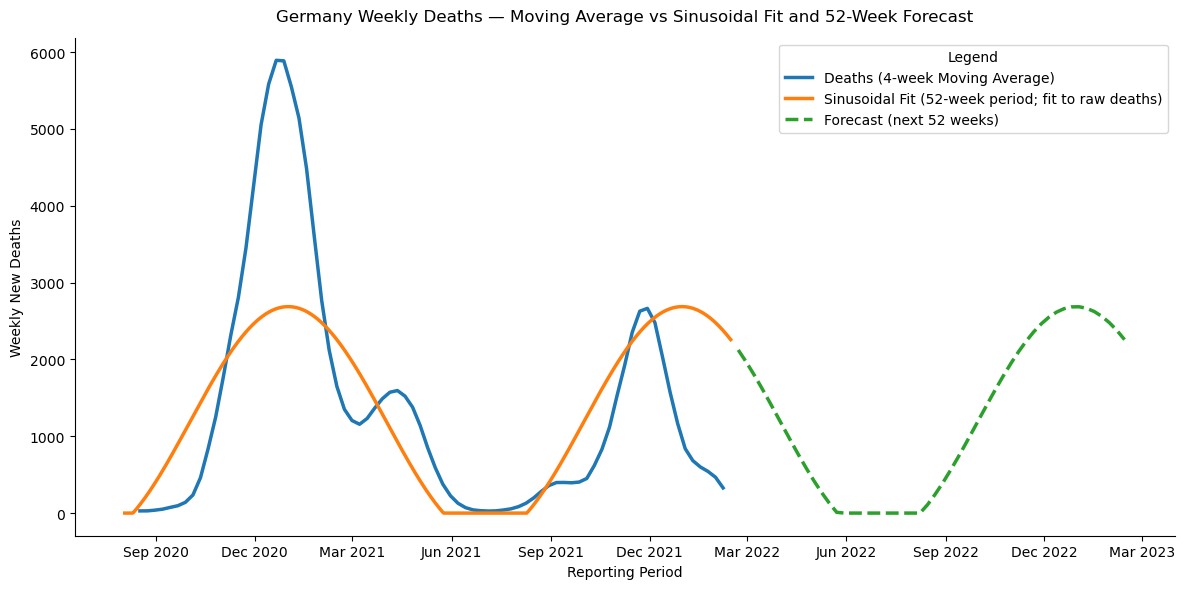

In [42]:
# --- Sinusoid with fixed 52-week period ---
def sinusoidal_fixed_period(x, a, c, d):
    b = 2 * np.pi / 52
    return a * np.sin(b * x + c) + d

# --- 1) Build Germany weekly raw deaths from df_germany (start Aug 2020) ---
df_germany["week_start"] = pd.to_datetime(df_germany["week_start"], errors="coerce")

start_date = pd.to_datetime("2020-08-01")

germany_weekly_raw = (
    df_germany.loc[df_germany["week_start"] >= start_date]
    .dropna(subset=["week_start", "new_deceased"])
    .loc[np.isfinite(df_germany.loc[df_germany["week_start"] >= start_date, "new_deceased"])]
    .groupby("week_start", as_index=True)["new_deceased"]
    .sum()
    .sort_index()
)

# Continuous week index for fitting
x_data = np.arange(len(germany_weekly_raw), dtype=float)
y_data = germany_weekly_raw.values.astype(float)

# --- 2) Fit sinusoid to RAW weekly deaths (Aug 2020+) ---
p0 = [y_data.max() - y_data.min(), 0.0, y_data.mean()]
params, _ = curve_fit(sinusoidal_fixed_period, x_data, y_data, p0=p0, maxfev=20000)
a, c, d = params

print("Fitted parameters (fixed 52-week period) on Germany raw weekly deaths (Aug 2020+):")
print(f"a (amplitude): {a}")
print(f"c (phase shift): {c}")
print(f"d (vertical shift): {d}")

# Fitted values on historical range (then clip at 0)
x_fit_hist = np.linspace(x_data.min(), x_data.max(), 800)
y_fit_hist = np.clip(sinusoidal_fixed_period(x_fit_hist, *params), 0, None)

# --- 3) Forecast next 52 weeks (then clip at 0) ---
next_52_weeks = np.arange(x_data.max() + 1, x_data.max() + 53, dtype=float)
next_52_predictions = np.clip(sinusoidal_fixed_period(next_52_weeks, *params), 0, None)

last_date = germany_weekly_raw.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=52, freq="W-MON")

predictions_df = pd.DataFrame(
    {"week_start": future_dates, "predicted_new_deceased": next_52_predictions}
)


# --- 4) Moving average for plotting (smoother observed deaths) ---
germany_weekly_ma4 = germany_weekly_raw.rolling(window=4, center=True).mean()

# --- 5) Convert x (continuous weeks) -> dates for plotting the sinusoid curves ---
date_index = germany_weekly_raw.index
date_positions = np.arange(len(date_index), dtype=float)

hist_fit_dates_num = np.interp(
    x_fit_hist, date_positions, mdates.date2num(date_index.to_pydatetime())
)
hist_fit_dates = mdates.num2date(hist_fit_dates_num)

# --- 6) Plot with your preferred styling ---
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    germany_weekly_ma4.index,
    germany_weekly_ma4.values,
    linewidth=2.5,
    label="Deaths (4-week Moving Average)"
)

ax.plot(
    hist_fit_dates,
    y_fit_hist,
    linewidth=2.5,
    label="Sinusoidal Fit (52-week period; fit to raw deaths)"
)

ax.plot(
    predictions_df["week_start"],
    predictions_df["predicted_new_deceased"],
    linewidth=2.5,
    linestyle="--",
    label="Forecast (next 52 weeks)"
)

ax.set_title("Germany Weekly Deaths — Moving Average vs Sinusoidal Fit and 52-Week Forecast", pad=12)
ax.set_xlabel("Reporting Period")
ax.set_ylabel("Weekly New Deaths")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(title="Legend", loc="upper right")

plt.tight_layout()
plt.show()

### Germany 52-Week Forecast — Seasonality Under High Volatility

Using the preferred **August 2020 onward** dataset, the same fixed-period (52-week) sinusoidal modeling approach applied to the U.S. was used to generate a forward-looking forecast for Germany.

Observed deaths are shown using a 4-week moving average, while the sinusoidal fit is applied to raw weekly deaths and extended 52 weeks into the future.

---

#### What This Forecast Represents — and What It Does Not

Unlike the U.S. series, Germany’s mortality trajectory exhibits **substantial volatility between waves**, particularly when comparing the magnitude of peaks in late 2020, early 2021, and late 2021. While the **timing** of seasonal peaks remains relatively consistent, the **amplitude varies considerably from year to year**.

As a result:

- The model captures **general seasonal directionality** (winter vs summer risk)
- It does *not* reliably capture **peak intensity**
- Forecast accuracy is therefore **moderate at best**, even under stable assumptions

This outcome is not a failure of the method, but a reflection of the underlying data-generating process.

---

#### Why This Is Expected for Pandemic Data

Public-health time series — especially during pandemics — are influenced by factors that a simple seasonal model cannot anticipate:

- Variant-specific severity
- Policy interventions and behavioral changes
- Health system strain and reporting adjustments
- Vaccination timing and population immunity shifts

Germany’s later waves differ meaningfully in scale despite occurring in similar seasons, limiting the predictive power of a fixed-amplitude seasonal model.

---

#### Key Insight

This forecast is best interpreted as a **baseline seasonal reference**, not a precise prediction.

It highlights *when* elevated risk may occur, rather than *how severe* future waves will be. In highly volatile environments, this distinction is critical:  
> capturing timing can still be valuable even when magnitude remains unpredictable.

This section reinforces a broader conclusion of the notebook:  
simple models can surface useful structure, but they must be accompanied by **clear communication of uncertainty** — especially in public-health contexts.


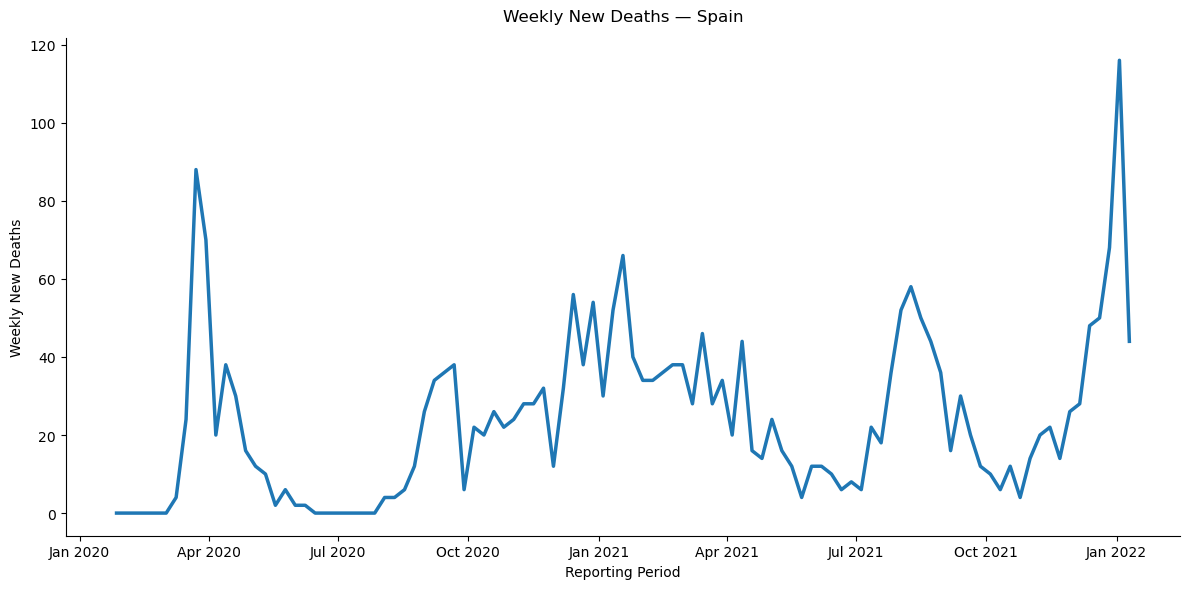

In [43]:
# Spain
# Ensure datetime typing
df_spain["week_start"] = pd.to_datetime(df_spain["week_start"], errors="coerce")

# Correct cutoff date for Spain death data
cutoff_date = pd.to_datetime("2022-01-13")

# Aggregate weekly deaths (cut off at last valid death date)
spain_weekly = (
    df_spain.loc[df_spain["week_start"] <= cutoff_date]
    .groupby("week_start", as_index=False)["new_deceased"]
    .sum()
    .sort_values("week_start")
    .dropna(subset=["week_start"])
)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    spain_weekly["week_start"],
    spain_weekly["new_deceased"],
    linewidth=2.5
)

# Titles & labels
ax.set_title("Weekly New Deaths — Spain", pad=12)
ax.set_xlabel("Reporting Period")
ax.set_ylabel("Weekly New Deaths")

# Month + Year x-axis formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

# Styling cleanup
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

### Spain — Data Credibility Comes First

Before any modeling or forecasting, the raw weekly death series for Spain raises an immediate red flag.

During the middle months of 2020 — when COVID had already spread across Europe — Spain reports **multiple consecutive weeks with zero recorded deaths**. Given the timing, geographic proximity, and known outbreak severity, this pattern is highly implausible.

---

#### Why This Matters

Periods of zero reported deaths at the onset of a pandemic may reflect:
- Delayed or incomplete reporting
- Retrospective data revisions
- Classification or attribution issues
- Structural gaps in surveillance infrastructure  

Regardless of the cause, the implication is the same: **the observed data cannot be taken at face value**.

---

#### Implications for Analysis and Forecasting

Because early inconsistencies undermine confidence in the series as a whole:

- Any inferred seasonality is less reliable  
- Forecasts derived from this data must be treated with heightened skepticism  
- Cross-country comparisons involving Spain require additional caution  

This does not mean the data is unusable — but it does mean that **interpretation must be conservative and explicitly caveated**.

---

#### Key Insight

Modeling decisions are not purely technical.

An analyst’s responsibility begins **before** fitting models, by evaluating whether the underlying data plausibly reflects reality. Recognizing when data quality limits what can be concluded is as important as producing forecasts themselves.

In this case, skepticism is not a weakness — it is the correct analytical response.


Fitted parameters (fixed 52-week period) on Spain raw weekly deaths (Aug 2020 → Jan 13, 2022):
a (amplitude): 12.64274027880927
c (phase shift): -1.3336755883191231
d (vertical shift): 28.05778418545136


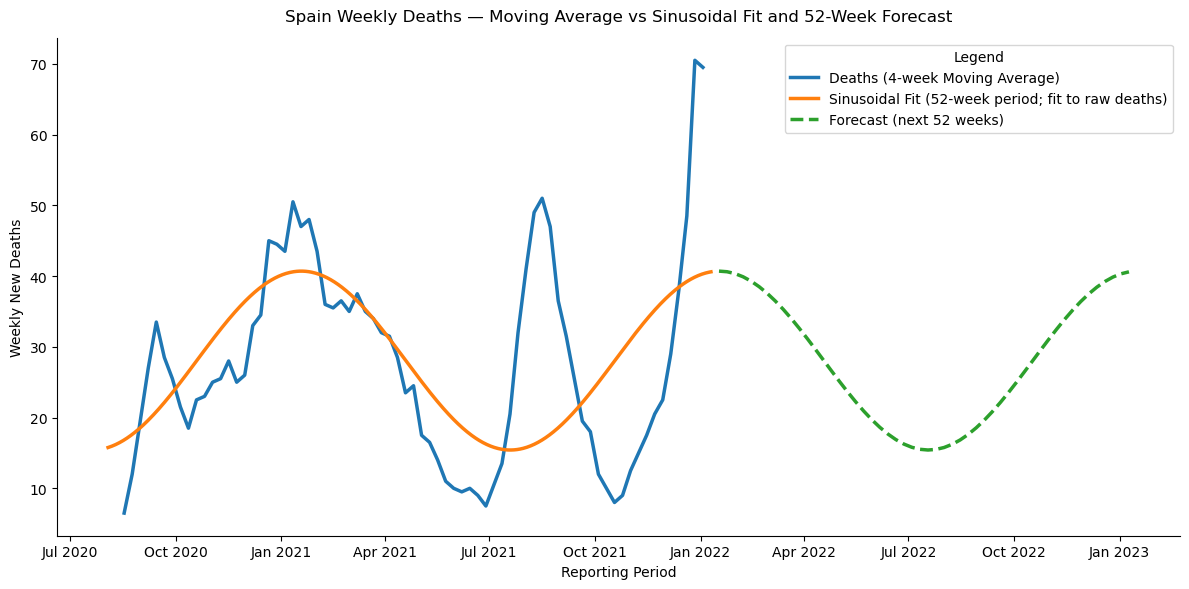

In [44]:
# --- Sinusoid with fixed 52-week period ---
def sinusoidal_fixed_period(x, a, c, d):
    b = 2 * np.pi / 52
    return a * np.sin(b * x + c) + d

# --- 1) Build Spain weekly raw deaths from df_spain (start Aug 2020; cutoff Jan 13, 2022) ---
df_spain["week_start"] = pd.to_datetime(df_spain["week_start"], errors="coerce")

start_date = pd.to_datetime("2020-08-01")
cutoff_date = pd.to_datetime("2022-01-13")

spain_weekly_raw = (
    df_spain.loc[(df_spain["week_start"] >= start_date) & (df_spain["week_start"] <= cutoff_date)]
    .dropna(subset=["week_start", "new_deceased"])
    .loc[np.isfinite(df_spain.loc[(df_spain["week_start"] >= start_date) & (df_spain["week_start"] <= cutoff_date), "new_deceased"])]
    .groupby("week_start", as_index=True)["new_deceased"]
    .sum()
    .sort_index()
)

# Continuous week index for fitting
x_data = np.arange(len(spain_weekly_raw), dtype=float)
y_data = spain_weekly_raw.values.astype(float)

# --- 2) Fit sinusoid to RAW weekly deaths (Aug 2020 -> Jan 13, 2022) ---
p0 = [y_data.max() - y_data.min(), 0.0, y_data.mean()]
params, _ = curve_fit(sinusoidal_fixed_period, x_data, y_data, p0=p0, maxfev=20000)
a, c, d = params

print("Fitted parameters (fixed 52-week period) on Spain raw weekly deaths (Aug 2020 → Jan 13, 2022):")
print(f"a (amplitude): {a}")
print(f"c (phase shift): {c}")
print(f"d (vertical shift): {d}")

# Fitted values on historical range (optional clip at 0)
x_fit_hist = np.linspace(x_data.min(), x_data.max(), 800)
y_fit_hist = sinusoidal_fixed_period(x_fit_hist, *params)

# Optional guardrail (deaths can't be negative): uncomment if needed
# y_fit_hist = np.clip(y_fit_hist, 0, None)

# --- 3) Forecast next 52 weeks (optional clip at 0) ---
next_52_weeks = np.arange(x_data.max() + 1, x_data.max() + 53, dtype=float)
next_52_predictions = sinusoidal_fixed_period(next_52_weeks, *params)

# Optional guardrail: uncomment if needed
# next_52_predictions = np.clip(next_52_predictions, 0, None)

last_date = spain_weekly_raw.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=52, freq="W-MON")

predictions_df = pd.DataFrame(
    {"week_start": future_dates, "predicted_new_deceased": next_52_predictions}
)

# --- 4) Moving average for plotting (smoother observed deaths) ---
spain_weekly_ma4 = spain_weekly_raw.rolling(window=4, center=True).mean()

# --- 5) Convert x (continuous weeks) -> dates for plotting the sinusoid curve ---
date_index = spain_weekly_raw.index
date_positions = np.arange(len(date_index), dtype=float)

hist_fit_dates_num = np.interp(
    x_fit_hist, date_positions, mdates.date2num(date_index.to_pydatetime())
)
hist_fit_dates = mdates.num2date(hist_fit_dates_num)

# --- 6) Plot with your preferred styling ---
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    spain_weekly_ma4.index,
    spain_weekly_ma4.values,
    linewidth=2.5,
    label="Deaths (4-week Moving Average)"
)

ax.plot(
    hist_fit_dates,
    y_fit_hist,
    linewidth=2.5,
    label="Sinusoidal Fit (52-week period; fit to raw deaths)"
)

ax.plot(
    predictions_df["week_start"],
    predictions_df["predicted_new_deceased"],
    linewidth=2.5,
    linestyle="--",
    label="Forecast (next 52 weeks)"
)

ax.set_title("Spain Weekly Deaths — Moving Average vs Sinusoidal Fit and 52-Week Forecast", pad=12)
ax.set_xlabel("Reporting Period")
ax.set_ylabel("Weekly New Deaths")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(title="Legend", loc="upper right")

plt.tight_layout()
plt.show()

### Spain Forecast — When Methodology Meets Data Limitations

Using the same principles applied to the U.S. and Germany, Spain’s data was cleaned by excluding the most inconsistent early-2020 period and fitting a fixed 52-week sinusoidal model to the remaining series. A 52-week forward projection was then generated.

Despite methodological consistency, the resulting forecast is **mediocre at best**.

---

#### Why This Result Is Not Surprising

Several factors limit the interpretability and predictive power of this model:

- **Volatile wave magnitudes**, even within the same season  
- **Abrupt spikes and drops** that a smooth seasonal curve cannot capture  
- **Short effective fitting window**, due to early data exclusions  
- **Questionable data credibility**, highlighted by implausible zero-death periods earlier in the series  

Even after cleaning, the remaining signal is noisy and unstable relative to the U.S. and Germany.

---

#### Garbage In, Garbage Out

This section reinforces a fundamental analytical reality:

> No amount of modeling sophistication can overcome unreliable or inconsistent inputs.

While the sinusoidal model does extract a seasonal *shape*, both the **timing and magnitude** of Spain’s observed peaks deviate meaningfully from the fitted curve. As a result, the forecast should be interpreted as illustrative rather than predictive.

---

#### Key Insight

Applying the *same* method across countries does not guarantee comparable results — nor should it.

Spain’s forecast underscores the analyst’s responsibility to recognize when data quality, volatility, or structural issues limit what can be reasonably concluded. In such cases, restraint and transparency are stronger analytical choices than forced precision.

Here, skepticism is not a caveat — it is the conclusion.


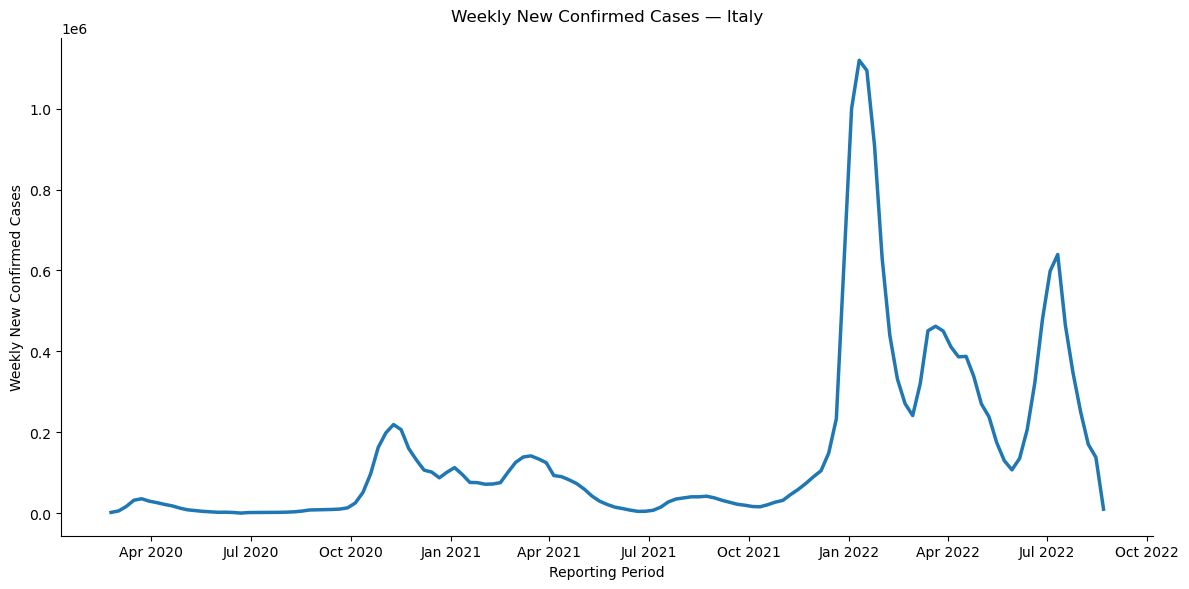

In [45]:
# Italy
# Ensure datetime typing
df_italy["week_start"] = pd.to_datetime(df_italy["week_start"], errors="coerce")

# Aggregate weekly NEW CASES (since Italy death data is unavailable)
italy_weekly = (
    df_italy
    .dropna(subset=["week_start", "new_confirmed"])
    .groupby("week_start", as_index=False)["new_confirmed"]
    .sum()
    .sort_values("week_start")
    .dropna(subset=["week_start"])
)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    italy_weekly["week_start"],
    italy_weekly["new_confirmed"],
    linewidth=2.5
)

# Titles & labels
ax.set_title("Weekly New Confirmed Cases — Italy", pad=12)
ax.set_xlabel("Reporting Period")
ax.set_ylabel("Weekly New Confirmed Cases")

# Month + Year x-axis formatting
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

# Styling cleanup
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()








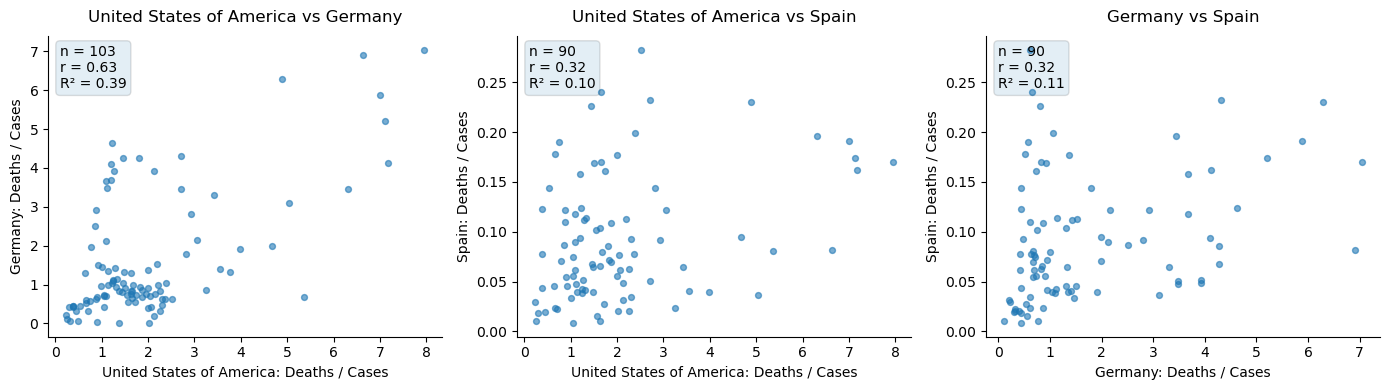


Cross-country correlation summary (Deaths/Cases vs Deaths/Cases):
                               Pair  Weeks Used (n)  Correlation coefficient (r)       R²      p-value
United States of America vs Germany             103                     0.626376 0.392347 1.479724e-12
                   Germany vs Spain              90                     0.324957 0.105597 1.778110e-03
  United States of America vs Spain              90                     0.322071 0.103730 1.963798e-03


In [46]:
countries = ["United States of America", "Germany", "Spain"]
metric = "new_deceased_over_new_confirmed"

# --- 1) Prep: keep only needed cols, enforce datetime, clean metric ---
df_metric = df.loc[df["country_name"].isin(countries), ["country_name", "week_start", metric]].copy()
df_metric["week_start"] = pd.to_datetime(df_metric["week_start"], errors="coerce")

df_metric[metric] = pd.to_numeric(df_metric[metric], errors="coerce")
df_metric = df_metric.dropna(subset=["week_start", metric])
df_metric = df_metric[np.isfinite(df_metric[metric])]

# Optional: remove zeros if you consider them non-informative / artifacts
df_metric = df_metric[df_metric[metric] > 0]

# --- 2) Weekly aggregation (if your df is already weekly, this is harmless; if not, it standardizes) ---
weekly_metric = (
    df_metric
    .groupby(["country_name", "week_start"], as_index=False)[metric]
    .mean()
)

# Pivot to wide so we can align countries by the same week_start
wide = weekly_metric.pivot(index="week_start", columns="country_name", values=metric).sort_index()

# --- 3) Define pairs to compare ---
pairs = [
    ("United States of America", "Germany"),
    ("United States of America", "Spain"),
    ("Germany", "Spain"),
]

# --- 4) Plot + stats (side-by-side) ---
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

summary_rows = []

for ax, (c1, c2) in zip(axes, pairs):
    # keep only overlapping weeks where BOTH countries have values
    sub = wide[[c1, c2]].dropna()

    x = sub[c1].values.astype(float)
    y = sub[c2].values.astype(float)

    # Stats
    if len(sub) < 3:
        r, p, r2 = np.nan, np.nan, np.nan
    else:
        r, p = pearsonr(x, y)
        r2 = r**2

    summary_rows.append({
        "Pair": f"{c1} vs {c2}",
        "Weeks Used (n)": len(sub),
        "Correlation coefficient (r)": r,
        "R²": r2,
        "p-value": p
    })

    # Scatter
    ax.scatter(x, y, alpha=0.6, s=18)

    # Labels
    ax.set_title(f"{c1} vs {c2}", pad=10)
    ax.set_xlabel(f"{c1}: Deaths / Cases")
    ax.set_ylabel(f"{c2}: Deaths / Cases")

    # Annotate
    ax.text(
        0.03, 0.97,
        f"n = {len(sub)}\nr = {r:.2f}\nR² = {r2:.2f}",
        transform=ax.transAxes,
        va="top",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", alpha=0.12)
    )

    # Styling cleanup
    ax.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

# --- 5) Print ranked summary ---
summary_df = pd.DataFrame(summary_rows).sort_values("Correlation coefficient (r)", ascending=False)

print("\nCross-country correlation summary (Deaths/Cases vs Deaths/Cases):")
print(summary_df.to_string(index=False))

### Creative Modeling for Italy — Inferring Deaths from Cross-Country Ratios

Italy presents a unique challenge in this analysis: **confirmed case data is available, but reliable death data is not**. Rather than discarding Italy entirely, we explore whether a *plausible* deaths-to-cases relationship can be inferred using patterns observed in other countries.

To do this, we examine **weekly deaths-to-confirmed-cases ratios** across countries where both metrics are available.

---

#### Comparing Countries by Deaths-to-Cases Ratios

Rather than comparing raw deaths or raw cases, this analysis focuses on the **ratio of deaths to confirmed cases**, which better reflects severity and reporting dynamics.

Pairwise comparisons were constructed for:

- United States vs Germany  
- United States vs Spain  
- Germany vs Spain  

Only weeks where *both* countries reported valid ratios were included.

---

#### Key Observation

Among the three pairs, **the United States and Germany exhibit the strongest statistical alignment**, with:

- The highest correlation coefficient (r)
- The highest explanatory power (R²)

This suggests that, relative to Spain, the U.S. and Germany share more similar dynamics in how deaths scale with confirmed cases — likely reflecting closer alignment in reporting practices, testing availability, and health-system response.

---

#### Why This Matters for Italy

Because Italy’s death data is missing, any estimation must rely on assumptions. Using the **U.S.–Germany relationship** as a reference provides:

- A data-driven basis for selecting a deaths-to-cases ratio  
- A transparent justification grounded in observed similarity  
- A more defensible alternative than arbitrarily choosing a single country  

This does **not** imply that Italy behaves identically to either country. Rather, it identifies the **most statistically consistent proxy available** under the constraint of missing data.

---

#### Important Caveat

This approach is explicitly **approximate**, not causal.

Deaths-to-cases ratios are influenced by:
- Demographics and age structure  
- Health system capacity  
- Testing intensity and case detection  
- Timing of outbreaks and interventions  

As such, the resulting estimates should be interpreted as **plausible orders of magnitude**, not precise reconstructions.

---

#### Key Insight

When critical data is missing, analysts must choose between abandoning analysis or constructing **transparent, assumption-aware proxies**.

This section demonstrates the latter:  
> using cross-country statistical alignment to build a defensible estimator, while clearly communicating uncertainty and limitations.

The goal is not perfection — it is *reasoned plausibility*.


In [47]:
def weighted_death_case_ratio(df_country):
    df_country = df_country.copy()

    df_country["new_confirmed"] = pd.to_numeric(df_country["new_confirmed"], errors="coerce")
    df_country["new_deceased"] = pd.to_numeric(df_country["new_deceased"], errors="coerce")

    df_country = df_country.dropna(subset=["new_confirmed", "new_deceased"])
    df_country = df_country[df_country["new_confirmed"] > 0]

    return df_country["new_deceased"].sum() / df_country["new_confirmed"].sum()


ratio_us = weighted_death_case_ratio(df_us)
ratio_de = weighted_death_case_ratio(df_germany)

ratio_combined = (
    df_us["new_deceased"].sum() + df_germany["new_deceased"].sum()
) / (
    df_us["new_confirmed"].sum() + df_germany["new_confirmed"].sum()
)

print(f"US weighted ratio:       {ratio_us:.6f}")
print(f"Germany weighted ratio:  {ratio_de:.6f}")
print(f"Combined weighted ratio: {ratio_combined:.6f}")
print(f"Combined ratio (%):      {ratio_combined * 100:.3f}%")


US weighted ratio:       0.011962
Germany weighted ratio:  0.009556
Combined weighted ratio: 0.011655
Combined ratio (%):      1.166%


Weighted deaths-to-cases ratios:
US weighted ratio:       0.011962
Germany weighted ratio:  0.009556
Combined weighted ratio: 0.011655 (1.166%)


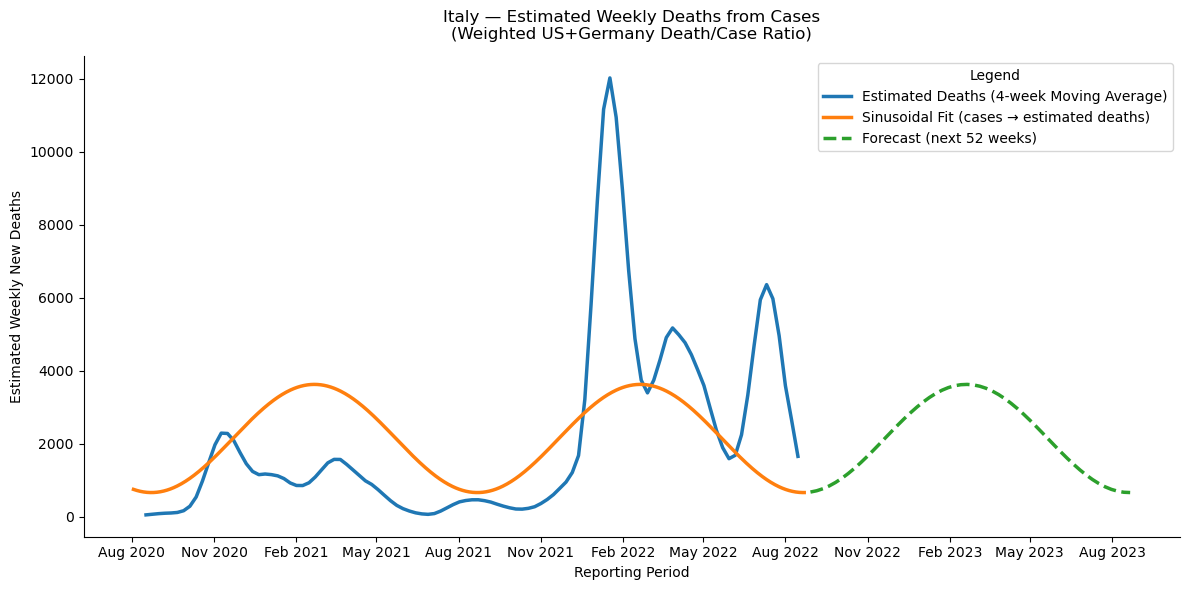

In [48]:

# -----------------------------
# 0) Helpers
# -----------------------------
def sinusoidal_fixed_period(x, a, c, d):
    b = 2 * np.pi / 52
    return a * np.sin(b * x + c) + d

# -----------------------------
# 1) Compute WEIGHTED deaths/cases ratio from US + Germany
# -----------------------------
df_us["week_start"] = pd.to_datetime(df_us["week_start"], errors="coerce")
df_germany["week_start"] = pd.to_datetime(df_germany["week_start"], errors="coerce")

def weighted_death_case_ratio(df_country):
    df_country = df_country.copy()
    df_country["new_confirmed"] = pd.to_numeric(df_country["new_confirmed"], errors="coerce")
    df_country["new_deceased"] = pd.to_numeric(df_country["new_deceased"], errors="coerce")
    df_country = df_country.dropna(subset=["new_confirmed", "new_deceased"])
    df_country = df_country[df_country["new_confirmed"] > 0]
    return df_country["new_deceased"].sum() / df_country["new_confirmed"].sum()

ratio_us = weighted_death_case_ratio(df_us)
ratio_de = weighted_death_case_ratio(df_germany)

# Combined weighted ratio (THIS is the key fix)
ratio_frac = (
    df_us["new_deceased"].sum() + df_germany["new_deceased"].sum()
) / (
    df_us["new_confirmed"].sum() + df_germany["new_confirmed"].sum()
)

print("Weighted deaths-to-cases ratios:")
print(f"US weighted ratio:       {ratio_us:.6f}")
print(f"Germany weighted ratio:  {ratio_de:.6f}")
print(f"Combined weighted ratio: {ratio_frac:.6f} ({ratio_frac*100:.3f}%)")

# -----------------------------
# 2) Italy: weekly CASES → estimated deaths
# -----------------------------
df_italy["week_start"] = pd.to_datetime(df_italy["week_start"], errors="coerce")

start_date = pd.to_datetime("2020-08-01")

italy_weekly_cases = (
    df_italy.loc[df_italy["week_start"] >= start_date]
        .dropna(subset=["week_start", "new_confirmed"])
        .assign(new_confirmed=pd.to_numeric(df_italy.loc[df_italy["week_start"] >= start_date, "new_confirmed"], errors="coerce"))
        .dropna(subset=["new_confirmed"])
        .loc[np.isfinite(df_italy.loc[df_italy["week_start"] >= start_date, "new_confirmed"])]
        .groupby("week_start", as_index=True)["new_confirmed"]
        .sum()
        .sort_index()
)

# Estimated deaths (observed period)
italy_weekly_est_deaths = italy_weekly_cases * ratio_frac

# -----------------------------
# 3) Fit sinusoid to RAW weekly CASES
# -----------------------------
x_data = np.arange(len(italy_weekly_cases), dtype=float)
y_cases = italy_weekly_cases.values.astype(float)

p0 = [y_cases.max() - y_cases.min(), 0.0, y_cases.mean()]
params, _ = curve_fit(sinusoidal_fixed_period, x_data, y_cases, p0=p0, maxfev=20000)

x_fit_hist = np.linspace(x_data.min(), x_data.max(), 800)
y_fit_cases_hist = np.clip(sinusoidal_fixed_period(x_fit_hist, *params), 0, None)
y_fit_est_deaths_hist = y_fit_cases_hist * ratio_frac

# -----------------------------
# 4) Forecast next 52 weeks
# -----------------------------
next_52_weeks = np.arange(x_data.max() + 1, x_data.max() + 53, dtype=float)
next_52_cases_pred = np.clip(sinusoidal_fixed_period(next_52_weeks, *params), 0, None)
next_52_est_deaths_pred = next_52_cases_pred * ratio_frac

last_date = italy_weekly_cases.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=52, freq="W-MON")

predictions_df = pd.DataFrame({
    "week_start": future_dates,
    "predicted_est_new_deceased": next_52_est_deaths_pred
})

# -----------------------------
# 5) Moving average (estimated deaths)
# -----------------------------
italy_est_deaths_ma4 = italy_weekly_est_deaths.rolling(window=4, center=True).mean()

# Convert continuous x → dates
date_index = italy_weekly_cases.index
date_positions = np.arange(len(date_index), dtype=float)
hist_fit_dates_num = np.interp(
    x_fit_hist, date_positions, mdates.date2num(date_index.to_pydatetime())
)
hist_fit_dates = mdates.num2date(hist_fit_dates_num)

# -----------------------------
# 6) Plot (final)
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    italy_est_deaths_ma4.index,
    italy_est_deaths_ma4.values,
    linewidth=2.5,
    label="Estimated Deaths (4-week Moving Average)"
)

ax.plot(
    hist_fit_dates,
    y_fit_est_deaths_hist,
    linewidth=2.5,
    label="Sinusoidal Fit (cases → estimated deaths)"
)

ax.plot(
    predictions_df["week_start"],
    predictions_df["predicted_est_new_deceased"],
    linewidth=2.5,
    linestyle="--",
    label="Forecast (next 52 weeks)"
)

ax.set_title(
    "Italy — Estimated Weekly Deaths from Cases\n(Weighted US+Germany Death/Case Ratio)",
    pad=12
)
ax.set_xlabel("Reporting Period")
ax.set_ylabel("Estimated Weekly New Deaths")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(title="Legend", loc="upper right")

plt.tight_layout()
plt.show()


### Italy — Estimating Deaths from Cases Using a Cross-Country Proxy

Italy lacks reliable death data for much of the pandemic period analyzed in this notebook. Rather than exclude Italy entirely, we construct a **plausible proxy** for weekly deaths by leveraging information from countries with more complete reporting.

Specifically, we compute a **weighted deaths-to-cases ratio** using data from the **United States and Germany**, the two countries shown earlier to have the strongest alignment in deaths-to-cases dynamics.

The resulting combined weighted ratio is approximately **1.17%**, which is then applied to Italy’s weekly confirmed case counts to estimate a corresponding deaths series.

---

#### From Proxy to Pattern

Once estimated weekly deaths are constructed:

- A 4-week moving average is used to smooth volatility
- A fixed 52-week sinusoidal regression is fit (via cases → estimated deaths)
- The fitted curve is extended forward to generate a 52-week forecast

This mirrors the methodology used for the U.S., Germany, and Spain, ensuring consistency across countries despite differing data availability.

---

#### Interpreting the Result

The estimated deaths series for Italy exhibits **extreme volatility**, particularly when comparing patterns in 2021 versus 2022. Peak magnitudes vary sharply across waves, even when seasonal timing appears similar.

As a result:

- The regression captures **directional increases and decreases**
- It performs poorly at estimating **absolute death counts**
- Forecasted values should *not* be interpreted as point predictions  

In this context, the model’s primary value is **temporal**, not numerical.

---

#### What This Model Is Actually Telling Us

For Italy, the sinusoidal fit and forecast are best read as answering the question:

> *When is the virus likely to re-emerge?*

—not:

> *How many people will die?*

This distinction is critical. The model surfaces **seasonal risk windows** rather than precise outcomes, which is often the most defensible conclusion when working with inferred or proxy-based data.

---

#### Key Insight

This section demonstrates a core analytical principle:

> When direct measurement is unavailable, carefully constructed proxies can still yield insight — provided their assumptions and limitations are made explicit.

The Italy analysis is intentionally imperfect. Its value lies not in precision, but in showing how analysts can adapt methodologically while remaining honest about uncertainty.

In that sense, the result is not a failure of modeling — it is a realistic reflection of the data.
